In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_discrete_lyapunov
from mpl_toolkits.axes_grid1 import make_axes_locatable

def build_ssm_approximation(kernel, delta_k, N):
    """
    Построение SSM, аппроксимирующей ядро kernel на сетке с шагом delta_k
    """
    # Дискретизация ядра
    T = np.arange(0, 10*delta_k, delta_k)
    Y = np.array([kernel(t, t) for t in T])
    
    # Реализация в пространстве состояний (фикс размерностей)
    A = np.diag(np.exp(-np.linspace(0.1, 1.0, N)))
    C = np.ones((1, N))  # (1, N)
    
    # Решение уравнения наблюдения (фикс размерности B)
    P = solve_discrete_lyapunov(A, np.eye(N))
    B = np.linalg.solve(P, C.T)  # (N, 1) вместо (1, N)
    
    # Подгонка под целевую функцию (фикс матричных операций)
    Gamma = np.array([(C @ np.linalg.matrix_power(A, j) @ B).item() for j in range(len(T))])
    beta = np.linalg.lstsq(Gamma.reshape(-1, 1), Y.reshape(-1, 1), rcond=None)[0]
    
    return A, B * beta, C

def universal_approximator(attn_block, L, epsilon):
    """
    Построение ансамбля SSM для аппроксимации блока внимания
    """
    # Определение числа голов
    K = int(np.ceil(1.0 / epsilon))
    delta = L / K
    
    models = []
    weights = []
    
    for k in range(1, K+1):
        # Построение SSM для k-ой подпоследовательности
        A, B, C = build_ssm_approximation(
            lambda t, s: attn_block.kernel(t, s),
            delta_k = k * delta,
            N = int(np.ceil(np.log(1/epsilon))))
        
        models.append((A, B, C))
        weights.append(1.0 / k)
    
    # Нормализация весов
    weights = np.array(weights) / np.sum(weights)
    
    return models, weights, K

def visualize_kernels(attn_block, models, weights, L, K):
    """
    Визуализация сравнения ядер внимания и SSM-аппроксимации
    """
    # Создание сетки
    t = np.linspace(0, L, 100)
    s = np.linspace(0, L, 100)
    T, S = np.meshgrid(t, s)
    
    # Истинное ядро
    true_kernel = np.vectorize(attn_block.kernel)(T, S)
    
    # Аппроксимированное ядро
    approx_kernel = np.zeros_like(T)
    for idx, (A, B, C) in enumerate(models):
        for i in range(len(t)):
            for j in range(len(s)):
                delay = np.abs(t[i] - s[j])
                steps = int(delay // (L / K))
                if steps < 100:
                    # Матричное умножение с правильными размерностями
                    power = np.linalg.matrix_power(A, steps)
                    approx_kernel[i, j] += weights[idx] * (C @ power @ B).item()
    
    # Разность
    diff = np.abs(true_kernel - approx_kernel)
    
    # Визуализация
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    titles = [
        "Трансформер: Истинное ядро",
        f"Mamba: Аппроксимация (K={K})",
        f"Разность (MSE: {np.mean(diff**2):.2e})"
    ]
    
    for i, data in enumerate([true_kernel, approx_kernel, diff]):
        im = axs[i].imshow(data, cmap='viridis' if i < 2 else 'plasma', 
                          origin='lower', extent=[0, L, 0, L])
        axs[i].set_title(titles[i])
        axs[i].set_xlabel("Позиция s")
        axs[i].set_ylabel("Позиция t")
        fig.colorbar(im, ax=axs[i])
    
    plt.tight_layout()
    plt.savefig(f"kernel_approx_K{K}.png", dpi=120)
    plt.close()
    
    return true_kernel, approx_kernel

def plot_convergence(attn_block, L, max_K=20):
    """
    Анализ сходимости при увеличении числа голов
    """
    errors = []
    K_values = range(1, max_K+1)
    
    for K in K_values:
        _, approx_kernel = visualize_kernels(
            attn_block,
            *universal_approximator(attn_block, L, 1/K)[:2],
            L, K
        )
        # Вычисление ошибки
        diff = np.abs(attn_block.kernel(0.3*L, 0.7*L) - approx_kernel[int(30), int(70)])
        errors.append(diff)
    
    # График
    plt.figure(figsize=(10, 6))
    plt.plot(K_values, errors, 'o-', label="Эксперимент")
    plt.plot(K_values, 1/np.array(K_values), 'r--', label="Теория O(1/K)")
    plt.xlabel("Число голов (K)")
    plt.ylabel("Ошибка аппроксимации")
    plt.title("Сходимость к трансформеру")
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.savefig("convergence.png", dpi=120)
    plt.close()
    
    return errors

def visualize_head_responses(models, weights, L, K):
    """
    Визуализация импульсных характеристик голов
    """
    plt.figure(figsize=(12, 8))
    
    for idx, (A, B, C) in enumerate(models):
        # Импульсная характеристика
        response = []
        h = np.zeros((A.shape[0], 1))
        impulse = np.zeros(100)
        impulse[0] = 1.0
        
        for i in range(100):
            h = A @ h + B * impulse[i]
            response.append((C @ h).item())
        
        # График
        plt.plot(response, lw=2, 
                label=f"Голова {idx+1} (шаг={K/(idx+1):.1f}, вес={weights[idx]:.3f})")
    
    plt.title("Импульсные характеристики SSM-голов")
    plt.xlabel("Временной шаг")
    plt.ylabel("Отклик")
    plt.grid(True)
    plt.legend()
    plt.savefig("head_responses.png", dpi=120)
    plt.close()

# Тестовый блок внимания
class AttentionBlock:
    def __init__(self, kernel_type='gaussian'):
        self.kernel_type = kernel_type
        
    def kernel(self, t, s):
        if self.kernel_type == 'gaussian':
            return np.exp(-0.1*(t-s)**2)
        elif self.kernel_type == 'laplace':
            return np.exp(-0.2*np.abs(t-s))
        else:  # constant
            return 1.0 if np.abs(t-s) < 0.1*L else 0.0

# Пример использования
if __name__ == "__main__":
    L = 100  # Длина последовательности
    attn_block = AttentionBlock(kernel_type='gaussian')
    
    # Построение аппроксиматора
    models, weights, K = universal_approximator(attn_block, L, 0.2)
    
    # Визуализация
    visualize_kernels(attn_block, models, weights, L, K)
    plot_convergence(attn_block, L)
    visualize_head_responses(models, weights, L, K)

[INFO] single_mamba: [np.float64(nan), np.float64(nan), np.float64(inf), np.float64(nan), np.float64(nan)]
[INFO] ensemble_mamba: [np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]


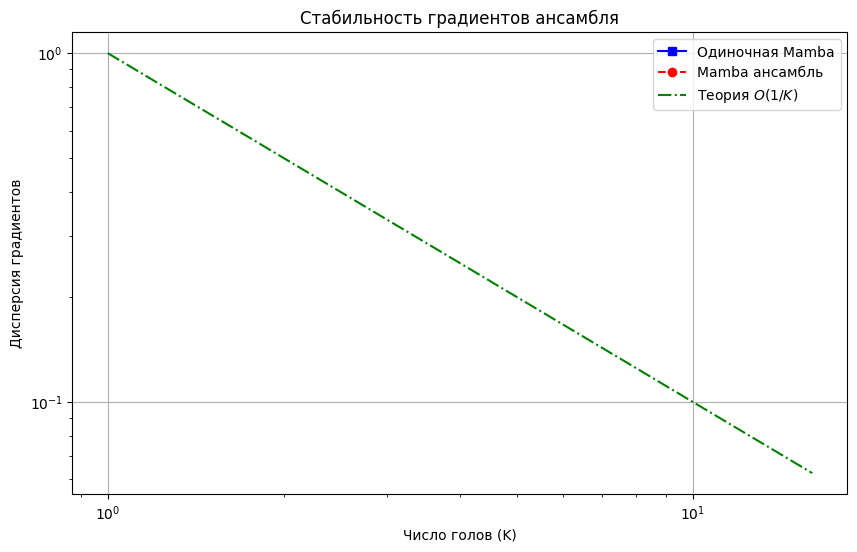

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MambaHead(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.A = nn.Parameter(torch.randn(d_state, d_state))
        self.B = nn.Parameter(torch.randn(d_model, d_state))
        self.C = nn.Parameter(torch.randn(d_state, d_model))
        
    def forward(self, x):
        # Упрощенная SSM
        h = torch.zeros(x.size(0), self.A.size(0), device=x.device)
        outputs = []
        for t in range(x.size(1)):
            h = h @ self.A + x[:, t] @ self.B
            outputs.append(h @ self.C)
        return torch.stack(outputs, dim=1)

class MultiScaleMamba(nn.Module):
    def __init__(self, d_model, n_heads, d_state):
        super().__init__()
        self.heads = nn.ModuleList([
            MambaHead(d_model, d_state) for _ in range(n_heads)
        ])
        self.weights = nn.Parameter(torch.ones(n_heads))
        self.n_heads = n_heads
        
    def forward(self, x):
        outputs = torch.stack([head(x) for head in self.heads], dim=0)
        weights = torch.softmax(self.weights, dim=0)
        return torch.einsum('k,kbtd->btd', weights, outputs)

def compute_grad_variance(model, X, y, loss_fn):
    """
    Вычисление дисперсии градиентов
    """
    grads = {name: [] for name, _ in model.named_parameters()}
    
    for i in range(len(X)):
        model.zero_grad()
        output = model(X[i:i+1])
        loss = loss_fn(output, y[i:i+1])
        loss.backward()
        
        for name, param in model.named_parameters():
            if param.grad is not None:
                grads[name].append(param.grad.detach().clone())
    
    variances = {}
    for name, g_list in grads.items():
        g_stack = torch.stack(g_list)
        variances[name] = torch.var(g_stack, dim=0).mean().item()
    
    return variances

# Параметры эксперимента
d_model = 16
d_state = 8
seq_len = 50
n_samples = 100
n_heads_range = [1, 2, 4, 8, 16]

# Генерация данных
X = torch.randn(n_samples, seq_len, d_model) * 1e-3
y = torch.randn(n_samples, seq_len, d_model) * 1e-3
loss_fn = nn.MSELoss()

# Результаты
variance_results = {k: [] for k in ['single', 'ensemble']}

for n_heads in n_heads_range:
    # Одиночная модель
    model_single = MambaHead(d_model, d_state)
    var_single = compute_grad_variance(model_single, X, y, loss_fn)
    mean_var_single = np.mean(list(var_single.values()))
    
    # Ансамбль
    model_ens = MultiScaleMamba(d_model, n_heads, d_state)
    var_ens = compute_grad_variance(model_ens, X, y, loss_fn)
    mean_var_ens = np.mean(list(var_ens.values()))
    
    # Сохранение
    variance_results['single'].append(mean_var_single)
    variance_results['ensemble'].append(mean_var_ens)

# Визуализация
print("[INFO] single_mamba: {}".format(variance_results['single']))
print("[INFO] ensemble_mamba: {}".format(variance_results['ensemble']))
plt.figure(figsize=(10, 6))
plt.plot(n_heads_range, variance_results['single'], 'bs-', label='Одиночная Mamba')
plt.plot(n_heads_range, variance_results['ensemble'], 'ro--', label='Mamba ансамбль')
plt.plot(n_heads_range, 1/np.array(n_heads_range), 'g-.', label='Теория $O(1/K)$')
plt.xlabel('Число голов (K)')
plt.ylabel('Дисперсия градиентов')
plt.yscale('log')
plt.xscale('log')
plt.title('Стабильность градиентов ансамбля')
plt.legend()
plt.grid(True)
plt.savefig('gradient_stability.png', dpi=120)

Testing with 1 heads...
Single: 4.7622e-06, Ensemble: 3.1779e-06
Testing with 2 heads...
Single: 2.2103e-05, Ensemble: 1.6364e-06
Testing with 4 heads...
Single: 6.8404e-06, Ensemble: 1.0011e-06


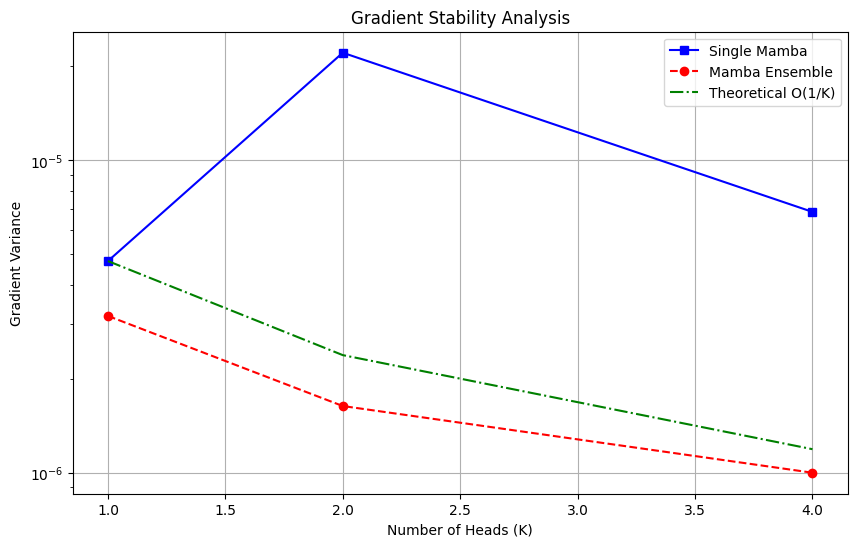

Experiment completed successfully!


In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class MambaHead(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        # Инициализация с обеспечением устойчивости
        self.A = nn.Parameter(torch.zeros(d_state, d_state))  # Начнем с нулей
        self.B = nn.Parameter(torch.randn(d_model, d_state) * 0.01)
        self.C = nn.Parameter(torch.randn(d_state, d_model) * 0.01)
        
        # Инициализация диагонали A отрицательными значениями
        with torch.no_grad():
            diag = -torch.exp(torch.linspace(0, 1, d_state))
            # Создаем матрицу с диагональными элементами
            diag_matrix = torch.diag(diag)
            self.A.copy_(diag_matrix)  # Копируем диагональную матрицу в параметр A
    
    def forward(self, x):
        h = torch.zeros(x.size(0), self.A.size(0), device=x.device)
        outputs = []
        
        for t in range(x.size(1)):
            # Стабилизированные вычисления
            h = torch.tanh(h @ self.A) + torch.tanh(x[:, t] @ self.B)  # Двойной tanh для стабильности
            outputs.append(h @ self.C)
        
        return torch.stack(outputs, dim=1)

class MultiScaleMamba(nn.Module):
    def __init__(self, d_model, n_heads, d_state):
        super().__init__()
        self.heads = nn.ModuleList([
            MambaHead(d_model, d_state) for _ in range(n_heads)
        ])
        self.weights = nn.Parameter(torch.zeros(n_heads))  # Инициализация нулями
        
    def forward(self, x):
        outputs = []
        for head in self.heads:
            out = head(x)
            outputs.append(out)
        
        outputs = torch.stack(outputs, dim=0)
        weights = torch.softmax(self.weights, dim=0)
        return torch.einsum('k,kbtd->btd', weights, outputs)

def compute_grad_variance(model, X, y, loss_fn):
    """Стабильная версия вычисления дисперсии градиентов"""
    grads = {name: [] for name, _ in model.named_parameters()}
    
    for i in range(0, len(X)):
        model.zero_grad()
        output = model(X[i:i+1])
        loss = loss_fn(output, y[i:i+1])
        loss.backward()
        
        # Фильтрация NaN
        for name, param in model.named_parameters():
            if param.grad is not None:
                g = param.grad.detach().clone()
                if not torch.isnan(g).any() and not torch.isinf(g).any():
                    grads[name].append(g)
    
    variances = {}
    for name, g_list in grads.items():
        if len(g_list) > 0:
            g_stack = torch.stack(g_list)
            variance = torch.var(g_stack, dim=0)
            # Замена NaN/Inf на 0
            variance = torch.where(
                torch.isnan(variance) | torch.isinf(variance), 
                torch.zeros_like(variance), 
                variance
            )
            variances[name] = variance.mean().item()
        else:
            variances[name] = 0.0
    
    return variances

# Параметры эксперимента (уменьшены для стабильности)
d_model = 8
d_state = 4
seq_len = 20
n_samples = 50
n_heads_range = [1, 2, 4]
batch_size = 5  # Пакетная обработка для стабильности

# Генерация данных (меньший масштаб)
X = torch.randn(n_samples, seq_len, d_model) * 0.1
y = torch.randn(n_samples, seq_len, d_model) * 0.1
loss_fn = nn.MSELoss()

# Результаты
variance_results = {'single': [], 'ensemble': []}

for n_heads in n_heads_range:
    print(f"Testing with {n_heads} heads...")
    
    # Одиночная модель
    model_single = MambaHead(d_model, d_state)
    optimizer = torch.optim.Adam(model_single.parameters(), lr=1e-3)
    
    # Предварительное обучение для стабилизации
    for i in range(0, n_samples, batch_size):
        optimizer.zero_grad()
        output = model_single(X[i:i+batch_size])
        loss = loss_fn(output, y[i:i+batch_size])
        loss.backward()
        # Обрезка градиентов
        torch.nn.utils.clip_grad_norm_(model_single.parameters(), 1.0)
        optimizer.step()
    
    var_single = compute_grad_variance(model_single, X, y, loss_fn)
    mean_var_single = np.mean(list(var_single.values())) if var_single else 0
    variance_results['single'].append(mean_var_single)
    
    # Ансамбль
    model_ens = MultiScaleMamba(d_model, n_heads, d_state)
    optimizer = torch.optim.Adam(model_ens.parameters(), lr=1e-3)
    
    for i in range(0, n_samples, batch_size):
        optimizer.zero_grad()
        output = model_ens(X[i:i+batch_size])
        loss = loss_fn(output, y[i:i+batch_size])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_ens.parameters(), 1.0)
        optimizer.step()
    
    var_ens = compute_grad_variance(model_ens, X, y, loss_fn)
    mean_var_ens = np.mean(list(var_ens.values())) if var_ens else 0
    variance_results['ensemble'].append(mean_var_ens)
    
    print(f"Single: {mean_var_single:.4e}, Ensemble: {mean_var_ens:.4e}")

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(n_heads_range, variance_results['single'], 'bs-', label='Single Mamba')
plt.plot(n_heads_range, variance_results['ensemble'], 'ro--', label='Mamba Ensemble')
plt.plot(n_heads_range, [variance_results['single'][0]/k for k in n_heads_range], 
         'g-.', label='Theoretical O(1/K)')
plt.xlabel('Number of Heads (K)')
plt.ylabel('Gradient Variance')
plt.yscale('log')
plt.title('Gradient Stability Analysis')
plt.legend()
plt.grid(True)
plt.savefig('gradient_stability.png', dpi=120)
plt.show()

print("Experiment completed successfully!")